# And then there was data

Right, now we have an incling of the method we might use to get arms from a galaxy, let's see how it fares against actual data (from the beta of galaxy-builder)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.cluster import SpectralClustering
from ipywidgets import FloatProgress
from IPython.display import display
import json
with open('classification-dump.json') as f: classifications = json.load(f)
with open('subject-dump.json') as f: subjects = json.load(f)

np.random.seed(299792458)

In [2]:
# print(json.dumps(list(cls[0]['links']['subjects']), indent=1))
index, foo = (next(iter(filter(
    lambda s: s[1] == '6ee8db8f-2a1e-4d10-bcb9-1e5ec84f8f10',
    ((i, list(s['locations'][0].items())[0][1].split('/')[-1].split('.')[0]) for i, s in enumerate(subjects))
))))
subjectId = subjects[index]['id']
print(subjectId)

14813274


In [3]:
cls = list(filter(lambda c: c['links']['subjects'][0] == subjectId, classifications))
annotations = [c['annotations'] for c in cls]
annotationsWithSpiral = [c[3]['value'][0]['value'] for c in annotations if len(c[3]['value'][0]['value'])]
spirals = [[a['points'] for a in c] for c in annotationsWithSpiral]
spiralsWithLengthCut = [
    [
        [[p['x'], p['y']] for p in a] 
        for a in c
    ]
    for c in spirals if all([len(a) > 5 for a in c])
]

To ensure we've grabbed things correctly, let's plot all our drawn arms!

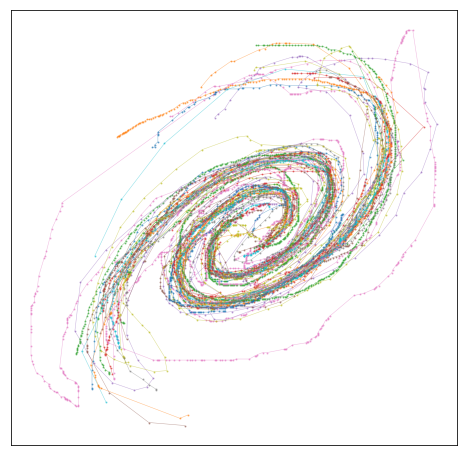

In [4]:
plt.figure(figsize=(8, 8))
plt.xticks([])
plt.yticks([])
for index, arms in enumerate(spiralsWithLengthCut):
    for arm in arms:
        plt.plot([i[0] for i in arm], [i[1] for i in arm], '.', markersize=2, alpha=0.5, c='C{}'.format(index % 10))
        plt.plot([i[0] for i in arm], [i[1] for i in arm], '', linewidth=0.5, alpha=0.5, c='C{}'.format(index % 10))

It looks good! ALbeit very messy... Now to run the extraction on it

First step is to move the array of classifications into an array of drawn arms (ignoring the potentially useful information that each volunteer will only have drawn each arm once...)

In [5]:
drawnArms = np.array([np.array(arm) for classification in spiralsWithLengthCut for arm in classification])

## Import the algorithm

Because I don't know how to best use jupyter, redo some of the cells from the previous chapter:

In [6]:
# calculate dot(a) of a(n,2), b(n,2): np.add.reduce(b1 * b2, axis=1)
# calucalte norm(a) of a(n,2), b(n,2): np.add.reduce((a-b)**2, axis=1)
def calcT(a):
    b1 = a[:, 0, :] - a[:, 1, :]
    b2 = a[:, 2, :] - a[:, 1, :]
    dots = np.add.reduce(b1 * b2, axis=1)
    l2 = np.add.reduce((a[:, 1] - a[:, 2])**2, axis=1)
    out = np.clip(dots / l2, 0, 1)
    return out

def getDiff(t, a):
    projection = a[:,1,:] + np.repeat(t.reshape(-1, 1), 2, axis=1) * (a[:,2,:] - a[:,1,:])
    out = np.add.reduce((a[:,0,:]-projection) * (a[:,0,:]-projection), axis=1)
    return np.sqrt(np.min(out))

vCalcT = np.vectorize(calcT, signature='(a,b,c)->(a)')
vGetDiff = np.vectorize(getDiff, signature='(a),(a,b,c)->()')

def minimum_distance(a, b):
    d = 0
#     print(np.roll(b, 1, axis=0))
    m = np.zeros((a.shape[0], b.shape[0]-1, 3, 2))
    m[:, :, 0, :] = np.transpose(np.tile(a, [m.shape[1]+1, 1, 1]), axes=[1, 0, 2])[:, :-1, :]
    m[:, :, 1, :] = np.tile(b, [a.shape[0], 1, 1])[:, :-1, :]
    m[:, :, 2, :] = np.tile(np.roll(b, -1, axis=0), [a.shape[0], 1, 1])[:, :-1, :]
    t = vCalcT(np.array(m))
    return np.sum(vGetDiff(t, m))/a.shape[0]
    
def arcDistanceFast(a, b):
    return (
        minimum_distance(a, b) +
        minimum_distance(b, a)
    )

## Identifying arms

First, create the distances array as before:

Widget Javascript not detected.  It may not be installed properly. Did you enable the widgetsnbextension? If not, then run "jupyter nbextension enable --py --sys-prefix widgetsnbextension"


62.256958961486816


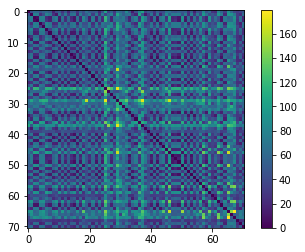

In [7]:
import time
def calculateDistanceMatrix(cls):
    n = len(cls)**2/2 - len(cls)/2
    f = FloatProgress(min=0, max=n)
    display(f)
    distances = np.zeros((len(cls), len(cls)))
    t0 = time.time()
    for i in range(len(cls)):
        for j in range(i+1, len(cls)):
            f.value += 1
            distances[i,j] = arcDistanceFast(cls[i], cls[j])
    distances += np.transpose(distances)
    return distances

t0 = time.time()

distances = calculateDistanceMatrix(drawnArms)

print(time.time() - t0)

plt.imshow(distances)
plt.colorbar()

Now make use of DBSCAN to group arms, defining the max distance between two arms in a core group to be 20, partially guided by our plot above.

In [8]:
# initialise fitter and fit! 
db = DBSCAN(eps=20, min_samples=3, metric='precomputed', n_jobs=-1, algorithm='brute')
db.fit(distances)

# Obtain clustering results
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
armLabels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(armLabels)) - (1 if -1 in armLabels else 0)

print('Estimated number of clusters: %d' % n_clusters_)

Estimated number of clusters: 2


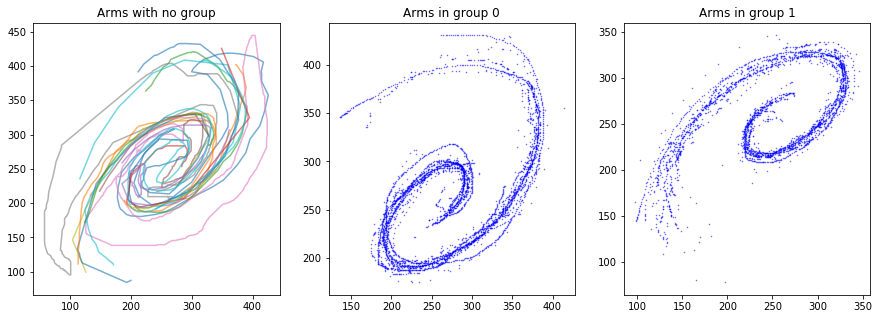

In [9]:
fig, ax = plt.subplots(ncols=len(np.unique(armLabels)), figsize=(15, 5))
for i, label in enumerate(np.unique(armLabels)):
    if label == -1:
        ax[i].set_title('Arms with no group')
    else:
        ax[i].set_title('Arms in group {}'.format(label))
    identified = drawnArms[np.where(armLabels == label)]
    for arm in identified:
        ax[i].plot(arm[:, 0], arm[:, 1], ('b.' if i > 0 else ''), markersize=1, alpha=0.6)


Well we have arms!!

The next step is to order the points in such a way we can fit a curved spline to them. We pick the arm with $\mathrm{label}=0$ to demonstrate

In [10]:
label = 0
pointCloud = np.array([
    point for arm in drawnArms[armLabels == label] 
    for point in arm
])

In [11]:
print('Total number of points:', np.array([point for arm in drawnArms for point in arm]).shape[0])
print('Arm 0 number of points:', pointCloud.shape)

Total number of points: 8101
Arm 0 number of points: (3743, 2)


In [12]:
from scipy.interpolate import UnivariateSpline

def rThetaFromXY(x, y, mux=0, muy=0):
    return np.sqrt((x - mux)**2 + (y - muy)**2), np.arctan2((y - muy),(x - mux))

def xyFromRTheta(r, theta, mux=0, muy=0):
    return mux + r*np.cos(theta), muy + r*np.sin(theta)

## Cleaning up the data

Let's make use of some outlier detection to clean up the data as best as possible. 

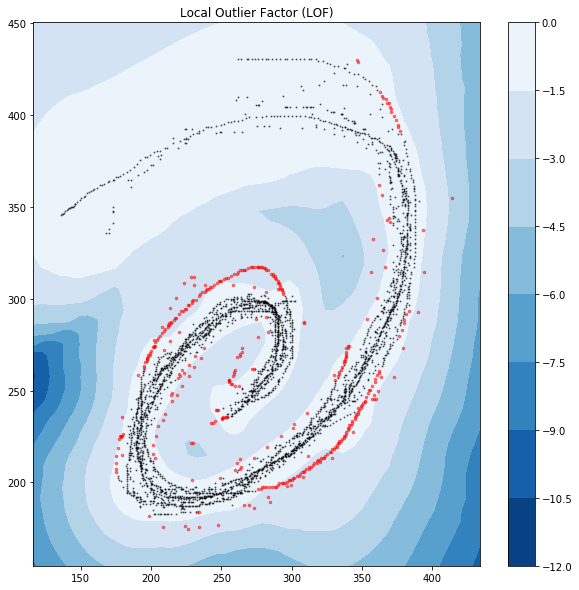

In [13]:
from sklearn.neighbors import LocalOutlierFactor
clf = LocalOutlierFactor(n_neighbors=50)
y_pred = clf.fit_predict(pointCloud)
mask = ((y_pred + 1) / 2).astype(bool)

# make grid for countours
xx, yy = np.meshgrid(
    np.linspace(np.min(pointCloud[:, 0]) - 20, np.max(pointCloud[:, 0]) + 20, 50), 
    np.linspace(np.min(pointCloud[:, 1]) - 20, np.max(pointCloud[:, 1]) + 20, 50)
)
Z = clf._decision_function(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# clean the point cloud
cleanedCloud = pointCloud[mask]
dirtyCloud = pointCloud[np.logical_not(mask)]


fig, ax = plt.subplots(ncols=1, figsize=(10, 10))
ax.set_title("Local Outlier Factor (LOF)")
ct = ax.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
ax.plot(cleanedCloud[:, 0], cleanedCloud[:, 1], 'k.', markersize=2, alpha=0.5)
ax.plot(pointCloud[np.logical_not(mask), 0], pointCloud[np.logical_not(mask), 1], 'r.', markersize=5, alpha=0.5)
cbar = plt.colorbar(ct)

# Ordering points

In order to fit a smoothed spline to the data points, we must first unwrap the spiral somehow, in a way which makes as few assumptions as possible. The method used in chapter one clumps data points and then orders inside this clump by theta from a central point, but still assumes almost circular symmetry, which will not be the general case. A new tactic has been devised:

## Finding the most arm-y arm of all the arms

Using our Local Outlier Factor decision function, we can find which arm contains points which are considered overall to be the least abnormal (normalised by the number of points in that arm)

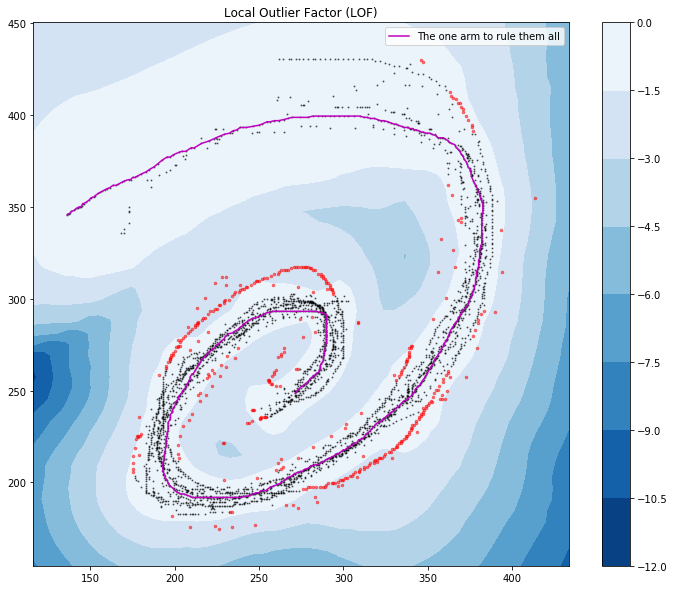

In [14]:
i = np.argmax([np.sum(clf._decision_function(arm[:10]))/arm.shape[0] for arm in drawnArms[armLabels == label]])

fig, ax = plt.subplots(ncols=1, figsize=(12, 10))
ax.set_title("Local Outlier Factor (LOF)")
ct = ax.contourf(xx, yy, Z, cmap=plt.cm.Blues_r)
ax.plot(cleanedCloud[:, 0], cleanedCloud[:, 1], 'k.', markersize=2, alpha=0.5)
ax.plot(pointCloud[np.logical_not(mask), 0], pointCloud[np.logical_not(mask), 1], 'r.', markersize=5, alpha=0.5)
cbar = plt.colorbar(ct)

arm = drawnArms[armLabels == label][i]
ax.plot(arm[:, 0], arm[:, 1], 'm', label='The one arm to rule them all')
ax.legend()

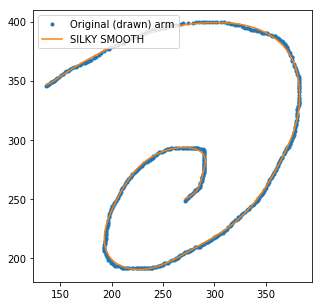

In [24]:
from scipy.interpolate import UnivariateSpline
t = np.linspace(0, 1, arm.shape[0])

Sx = UnivariateSpline(t, arm[:, 0], s=512, k=5)
Sy = UnivariateSpline(t, arm[:, 1], s=512, k=5)

smoothedArm = np.stack((Sx(t), Sy(t)), axis=1)

plt.figure(figsize=(5, 5))
plt.plot(arm[:, 0], arm[:, 1], '.', label='Original (drawn) arm')
plt.plot(smoothedArm[:, 0], smoothedArm[:, 1], label='SILKY SMOOTH')
plt.legend()

Now we have this arm, and a smoothed version of it, we can order the rest of our points!

To do this, we make use of parts of the distance algorithm defined above, and find the bit of the most army arm closest to each point, and create an array of values containing far along the most army arm this nearest point is. We can then order the point

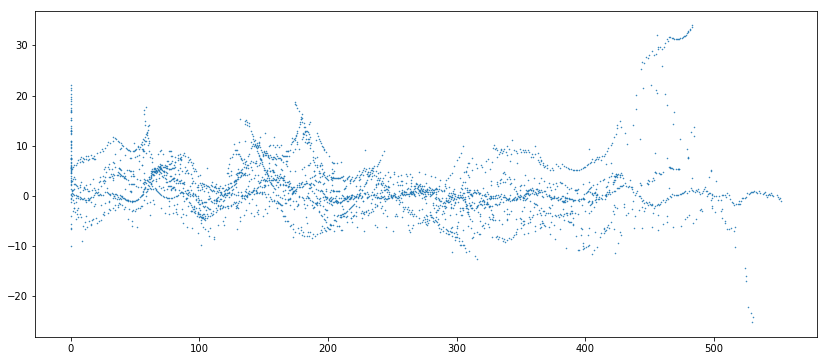

In [16]:
def calcT2(a):
    b1 = a[:, 0, :] - a[:, 1, :]
    b2 = a[:, 2, :] - a[:, 1, :]
    dots = np.add.reduce(b1 * b2, axis=1)
    l2 = np.add.reduce((a[:, 1] - a[:, 2])**2, axis=1)
    out = np.clip(dots / l2, 0, 1)
    return out

def sign(a):
    b1 = a[:, 0, :] - a[:, 1, :]
    b2 = a[:, 2, :] - a[:, 1, :]
    paddedB1 = np.pad(b1, ((0, 0), (0, 1)), 'constant', constant_values=(0,))
    paddedB2 = np.pad(b2, ((0, 0), (0, 1)), 'constant', constant_values=(0,))
    return np.sign(np.cross(paddedB1, paddedB2, axisa=1, axisb=1))[:, 2]

def getDiff2(t, a):
    projection = a[:,1,:] + np.repeat(t.reshape(-1, 1), 2, axis=1) * (a[:,2,:] - a[:,1,:])
    out = np.add.reduce((a[:,0,:]-projection) * (a[:,0,:]-projection), axis=1)
    return np.sqrt(out)

vCalcT2 = np.vectorize(calcT2, signature='(a,b,c)->(a)')
vGetDiff2 = np.vectorize(getDiff2, signature='(a),(a,b,c)->(a)')
vSign = np.vectorize(sign, signature='(a,b,c)->(a)')

def getDistAlongLine(pointsToOrder, line):
    # construct the tensor
    m = np.zeros((pointsToOrder.shape[0], line.shape[0]-1, 3, 2))
    m[:, :, 0, :] = np.transpose(np.tile(pointsToOrder, [m.shape[1]+1, 1, 1]), axes=[1, 0, 2])[:, :-1, :]
    m[:, :, 1, :] = np.tile(line, [pointsToOrder.shape[0], 1, 1])[:, :-1, :]
    m[:, :, 2, :] = np.tile(np.roll(line, -1, axis=0), [pointsToOrder.shape[0], 1, 1])[:, :-1, :]
    
    # 
    t = vCalcT2(np.array(m))
    signs = vSign(np.array(m))
    distances = vGetDiff2(t, m)
    minDistIndex = np.argmin(distances, axis=1)
    asd = np.dstack((np.arange(minDistIndex.shape[0]), minDistIndex))[0]
    return minDistIndex + t[asd[:, 0], asd[:, 1]], distances[asd[:, 0], asd[:, 1]] * signs[asd[:, 0], asd[:, 1]]

deviationCloud = np.transpose(getDistAlongLine(cleanedCloud, smoothedArm))
plt.figure(figsize=(14, 6))
plt.plot(deviationCloud[:, 0], deviationCloud[:, 1], '.', markersize=1)

(3368, 2) (3368,)


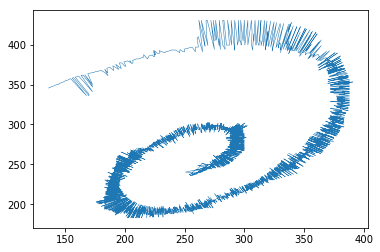

In [28]:
pointOrder = np.argsort(deviationCloud[:, 0])
sortedDeviationCloud = deviationCloud[np.argsort(deviationCloud[:, 0])]
print(cleanedCloud.shape, pointOrder.shape)
plt.plot(cleanedCloud[pointOrder, 0], cleanedCloud[pointOrder, 1], linewidth=0.5)

## And we have brought order to the galaxy

We can fit a smoothed spline, and view the fruits of our labour!!

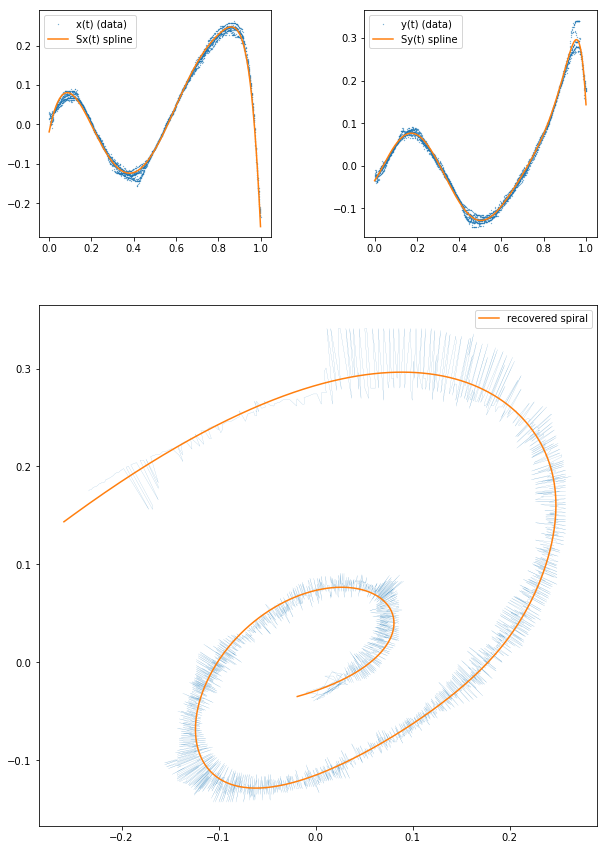

In [30]:
from scipy.interpolate import UnivariateSpline
plt.figure(figsize=(10, 15))

# for some reason the spline doesn't account for how far apart points are... yay! Normalise from -0.5 to 0.5
c2 = cleanedCloud / 512 - 0.5
t = np.linspace(0, 1, c2.shape[0])
Sx = UnivariateSpline(t, c2[pointOrder, 0], s=0.25, k=5)
Sy = UnivariateSpline(t, c2[pointOrder, 1], s=0.25, k=5)

grid = plt.GridSpec(3, 2, wspace=0.4, hspace=0.3)
ax1 = plt.subplot(grid[0, 0])
ax2 = plt.subplot(grid[0, 1])
ax3 = plt.subplot(grid[1:, 0:])

ax1.plot(t, c2[pointOrder,0], '.', markersize=0.5, label='x(t) (data)')
ax1.plot(t, Sx(t), label='Sx(t) spline')
ax1.legend()

ax2.plot(t, c2[pointOrder,1], '.', markersize=0.5, label='y(t) (data)')
ax2.plot(t, Sy(t), label='Sy(t) spline')
ax2.legend()

t2 = np.linspace(0, 1, c2.shape[0])
ax3.plot(c2[pointOrder, 0], c2[pointOrder, 1], linewidth=0.1)
ax3.plot(Sx(t2), Sy(t2), label='recovered spiral')

ax3.legend()

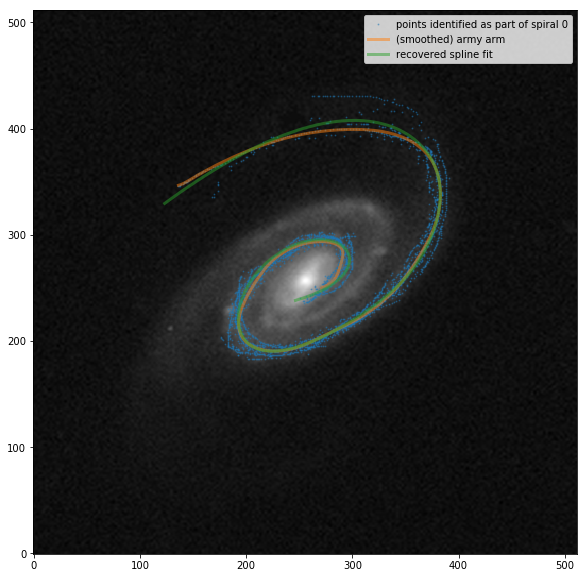

In [40]:
from PIL import Image
fig, ax = plt.subplots(ncols=1, figsize=(10, 10))

pointCloud2 = np.array([
    point for arm in drawnArms[armLabels == 1] 
    for point in arm
])

pic = Image.open("./images/beta_subject.png")
ax.imshow(np.transpose(np.array(pic)[::-1, ::1]), cmap='gray', origin='lower')

ax.plot(cleanedCloud[:, 0], cleanedCloud[:, 1], '.', markersize=2, alpha=0.4, label='points identified as part of spiral 0')
# ax.plot(pointCloud2[:, 0], pointCloud2[:, 1], '.', markersize=2, alpha=0.2, label='points identified as part of spiral 1 (not analysed here)')

ax.plot(smoothedArm[:, 0], smoothedArm[:, 1], linewidth=3, alpha=0.5, label='(smoothed) army arm')
ax.plot((Sx(t2)+0.5)*512, (Sy(t2)+0.5)*512, linewidth=3, alpha=0.5, label='recovered spline fit')

plt.legend()